# Code for the second report, Neural Modeling lecture

Sophie Atzpodien, December 2023

## Implementing the structure of the sequential decision task described in the book as well as the plotting function used for reproducing the graph

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
class Levers:
    def __init__(self):
        # defining states, actions, and rewards via dictionaries
        self.layers = 2 # maximal number of subsequent choices in the maze
        self.states = ['u1', 'u2', 'u3']
        self.actions = {'u1': ['L', 'C', 'R'],
                        'u2': ['L', 'R'],
                        'u3': ['L', 'R']}
        self.rewards = {'u1': {'L': 1, 'C': -1, 'R': 2},
                        'u2': {'L': 8, 'R': -8},
                        'u3': {'L': 0, 'R': 4}}
        self.states_values = {'u1': 0, 
                              'u2': 0, 
                              'u3': 0,
                              None: 0} # initializing the value function on the states, which will be updated while going through the labyrinth
        self.actions_values = {'u1': {'L': 0, 'C': 0, 'R': 0},
                               'u2': {'L': 0, 'R': 0},
                               'u3': {'L': 0, 'R': 0}}

    def step(self, state, action): # defining the possible action-dependent state transitions

        if state == 'u1' and action == 'C':
            next_state = np.random.choice(['u2', 'u3'])
       
        else:
            next_state = None

        reward = self.rewards[state][action]
        
        return next_state, reward
    
    def policy(self, state, beta): # calculating the current probability values for choosing an action in the current state based on current action values and softmax formula

        actions_factors = []
        actions_probs = []
        norm_prob = 0

        for poss_act in self.actions[state]:
            
            act_factor = np.exp(beta * self.actions_values[state][poss_act])
            actions_factors.append(act_factor)

            norm_prob += act_factor

        actions_probs = [a/norm_prob for a in actions_factors]

        return actions_probs
    
    def run(self, no_runs, no_trials, start_state, beta, learn_rate_critic, learn_rate_actor, decay_rate):

        values_hist = np.zeros((no_runs, no_trials, 3))
        probs_hist = np.zeros((no_runs, no_trials, 3, 3))


        for k in range(no_runs): 
            
            self.states_values = {'u1': 0, 
                                  'u2': 0, 
                                  'u3': 0,
                                  None: 0}

            self.actions_values  = {'u1': {'L': 0, 'C': 0, 'R': 0},
                                'u2': {'L': 0, 'R': 0},
                                'u3': {'L': 0, 'R': 0}}

            for n in range(no_trials):

                state = start_state
                
                for step in range(self.layers):

                    if state is not None:

                        probs = self.policy(state, beta)
                        action = np.random.choice(self.actions[state], p=probs)

                        next_state, reward = self.step(state, action)

                        delta = reward + self.states_values[next_state] - self.states_values[state]
                        
                        self.states_values[state] += learn_rate_critic * delta
                        
                        for poss_act in self.actions[state]:
                            
                            self.actions_values[state][poss_act] *= (1 - decay_rate)
                        
                        self.actions_values[state][action] += learn_rate_actor * delta
                        
                        state = next_state

                for id in range(3): #store state values and action probabilities for each state after each trial in a big 'history array' of values and probabilities, resp.

                    for id_act in range(len(self.actions[self.states[id]])):
                        
                        probs_hist[k, n, id, id_act] += self.policy(self.states[id], beta)[id_act]

                    values_hist[k, n, id] = self.states_values[self.states[id]]
    
        return values_hist, probs_hist
        
    def plot_results(self, values_array, probs_array, no_runs):

        fig, axs = plt.subplots(2, len(self.states), figsize=(15, 10), sharex='col')
        styles = ['--', '', ':']

        axs[0, 0].set_ylabel('value v(u)', fontsize=14)
        axs[1, 0].set_ylabel('P[a|u]', fontsize=14)

        for id in range(len(self.states)):

            axs[0, id].set_title(f'state {self.states[id]}', fontsize=14)
            axs[0, id].plot(np.average(values_array[:, :, id], axis=0), 'o',
                       label='average across %s experiments'%no_runs)
            axs[0, id].plot(values_array[np.random.randint(0, no_runs), :, id],
                       'k:', label='sample experiment')
            axs[0, id].legend(loc='lower right')

            for id_act in range(len(self.actions[self.states[id]])):
                
                axs[1, id].plot(np.average(probs_array[:, :, id, id_act],
                            axis=0), styles[id_act], label=self.actions[self.states[id]][id_act])
                axs[1, id].legend(title='average across %s experiments'%no_runs)
                axs[1, id].set_xlabel('trials', fontsize=14)

        axs[0][0].axhline(y=5, color='g', linestyle='--', label='optimal policy')
        axs[0][0].axhline(y=1, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][0].legend(loc='lower right')

        axs[0][1].axhline(y=8, color='g', linestyle='--', label='optimal policy')
        axs[0][1].axhline(y=0, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][1].legend(loc='lower right')
        axs[0][2].axhline(y=4, color='g', linestyle='--', label='optimal policy')
        axs[0][2].axhline(y=2, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][2].legend(loc='lower right')

        plt.tight_layout()
        plt.show()

        

## Policy evaluation 
(i.e. presuming an unbiased policy with equal probabilities for all available actions in each state)

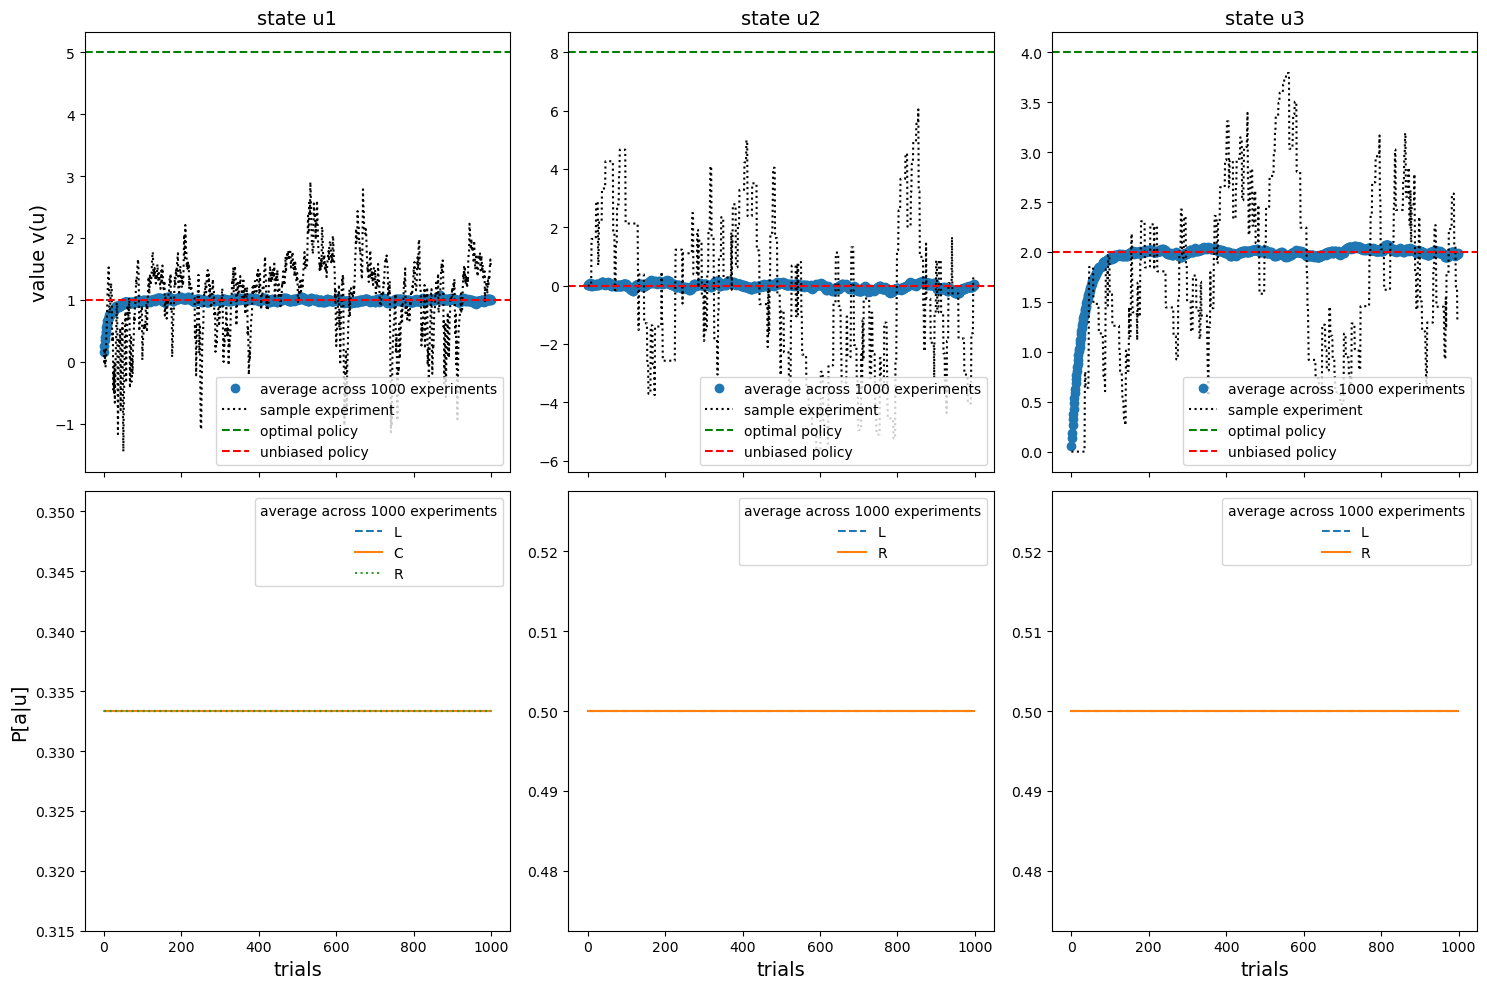

In [3]:
# set learn_rate_actor to 0 in order to simulate 'policy evaluation' for an unbiased policy (i.e. all actions are equiprobable in each state) 

policy_eval = Levers()

values_eval, probs_eval = policy_eval.run(1000, 1000, 'u1', 1, 0.2, 0, 0)

policy_eval.plot_results(values_eval, probs_eval, 1000)

## Policy improvement -- Actor-Critic-Learning

### Reproducing Figure 9.9
(beta = 1, critic_learning_rate = 0.2, actor_learning_rate = 0.075, no action value decay)

In [4]:
actor_critic = Levers()

values_actor_critic, probs_actor_critic = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.075, 0)


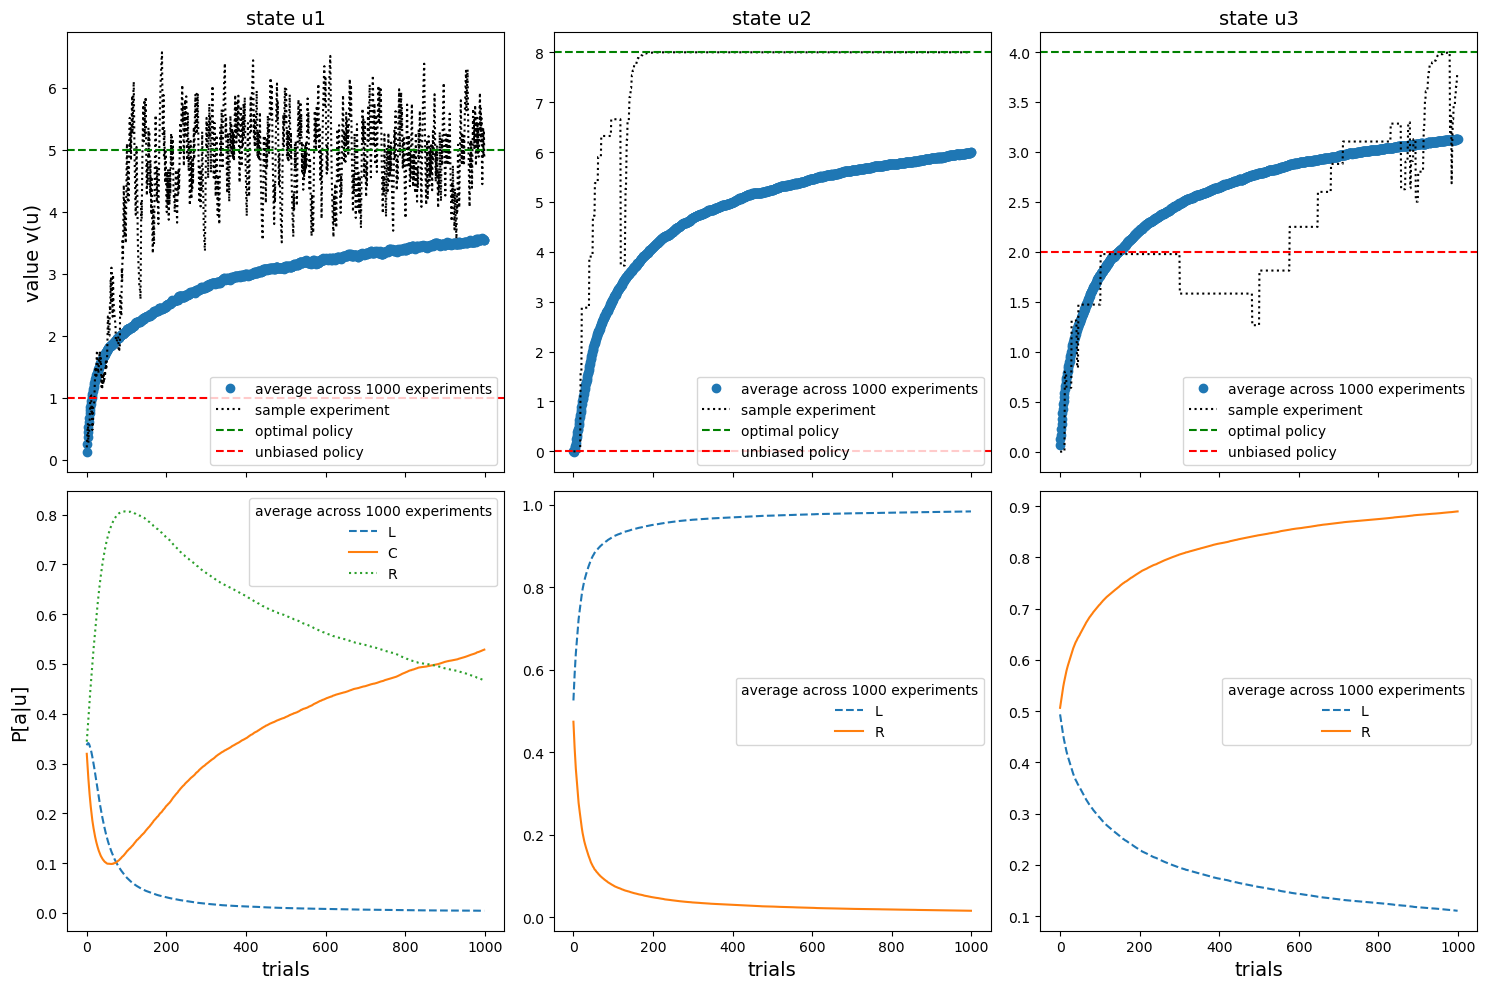

In [5]:
actor_critic.plot_results(values_actor_critic, probs_actor_critic, 1000)

### Playing around with the parameters, pt. I: Higher and lower inverse temperature beta

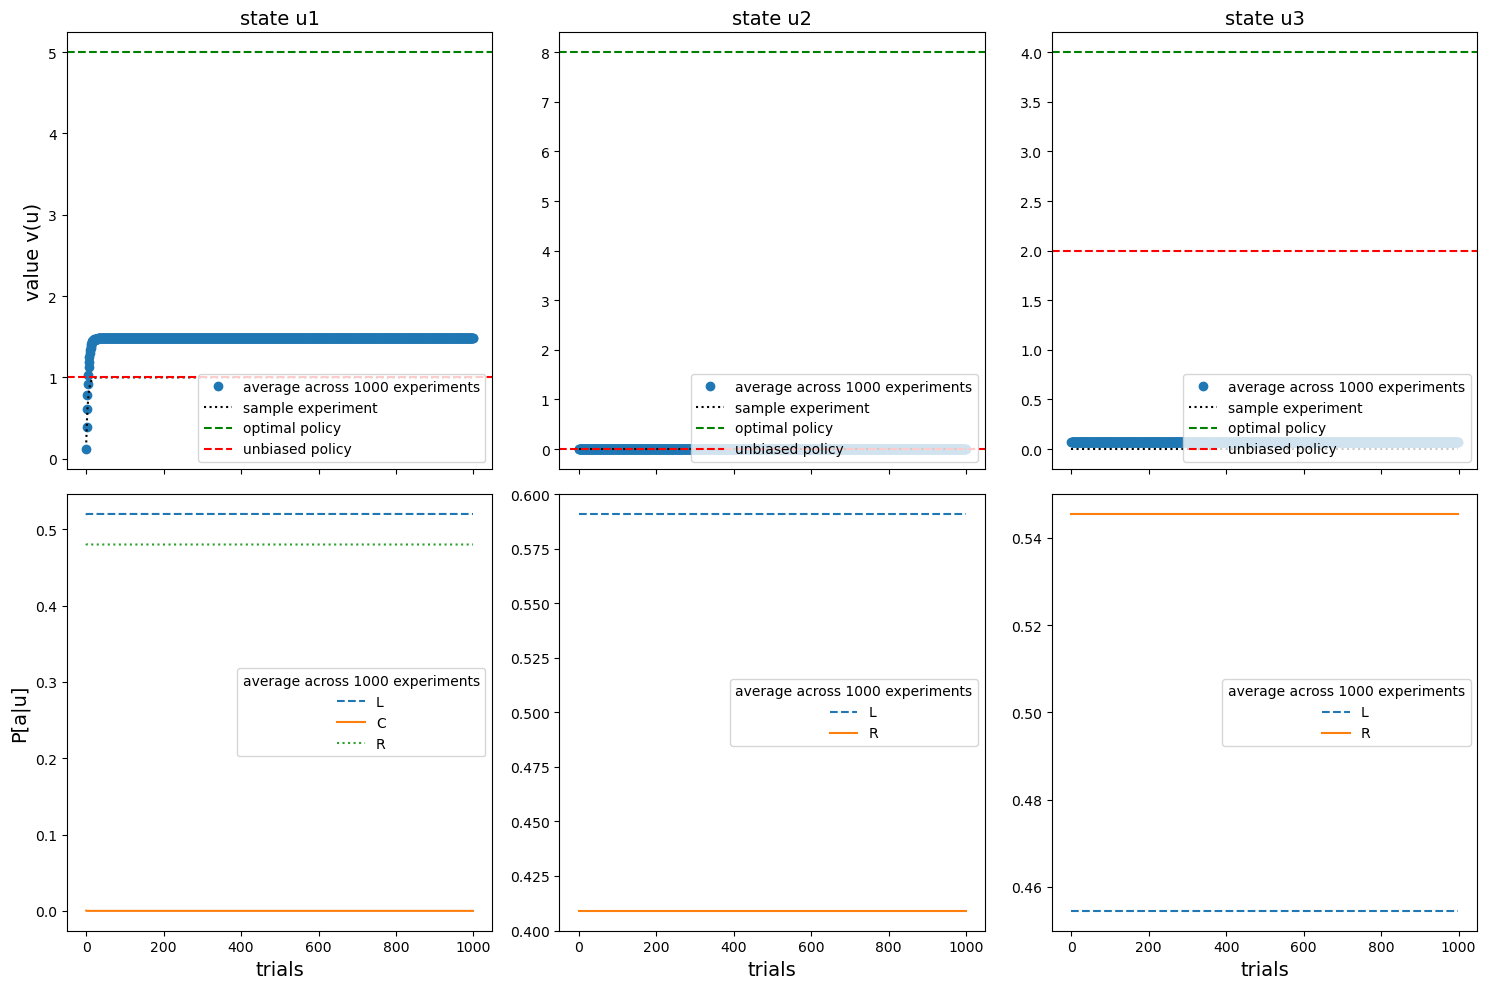

In [6]:
#high beta, i.e. we expect exploitative behavior which will possibly not converge to the optimal solution

actor_critic_highbeta = Levers()

values_highbeta, probs_highbeta = actor_critic_highbeta.run(1000, 1000, 'u1', 100, 0.2, 0.075, 0)

actor_critic_highbeta.plot_results(values_highbeta, probs_highbeta, 1000)

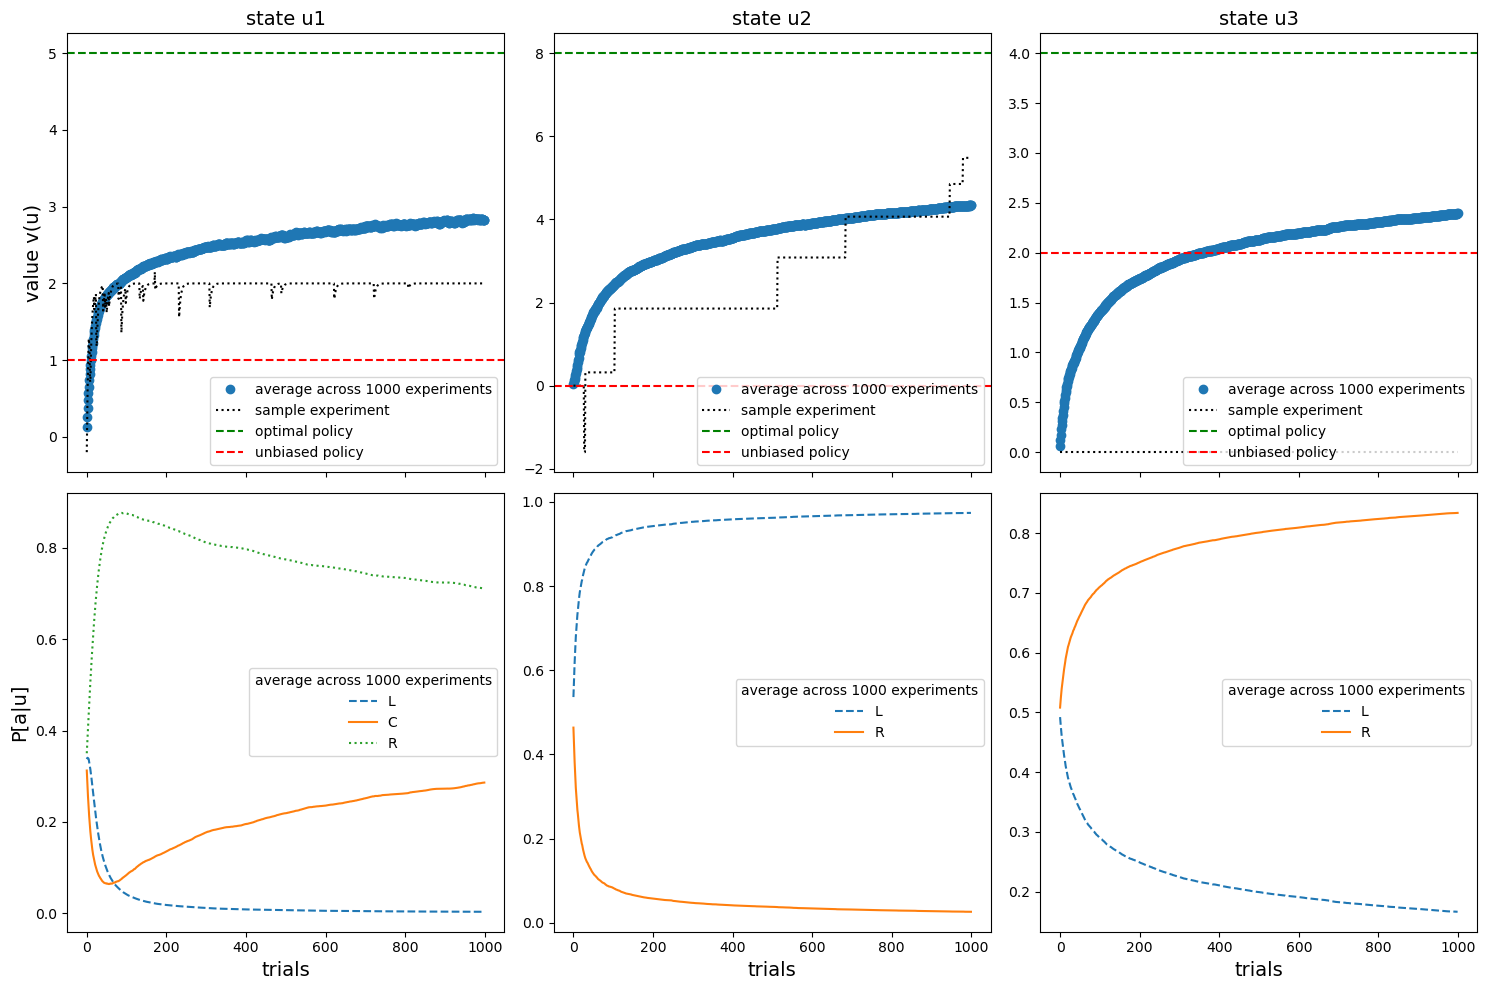

In [7]:
#high beta, i.e. we expect exploitative behavior which will possibly not converge to the optimal solution
actor_critic_highbeta = Levers()

values_highbeta, probs_highbeta = actor_critic_highbeta.run(1000, 1000, 'u1', 1.5, 0.2, 0.075, 0)

actor_critic_highbeta.plot_results(values_highbeta, probs_highbeta, 1000)

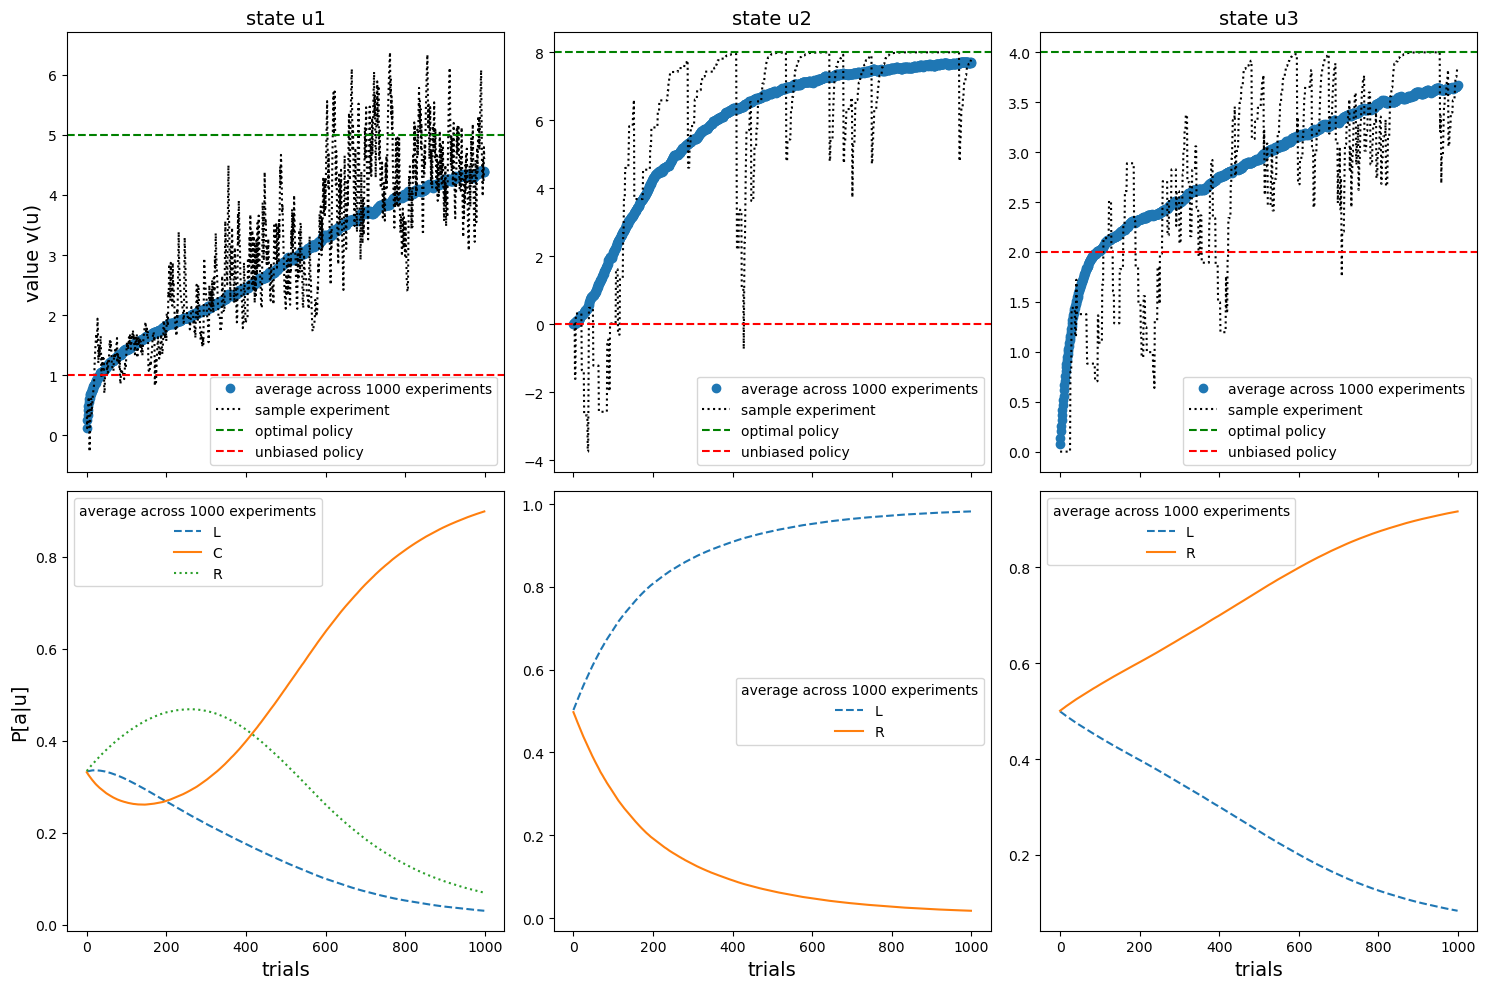

In [8]:
#low beta, i.e. we expect more exploratory behavior which will be more noisy, but probably still convergent

actor_critic_lowbeta = Levers()

values_lowbeta, probs_lowbeta = actor_critic_lowbeta.run(1000, 1000, 'u1', 0.1, 0.2, 0.075, 0)

actor_critic_lowbeta.plot_results(values_lowbeta, probs_lowbeta, 1000)

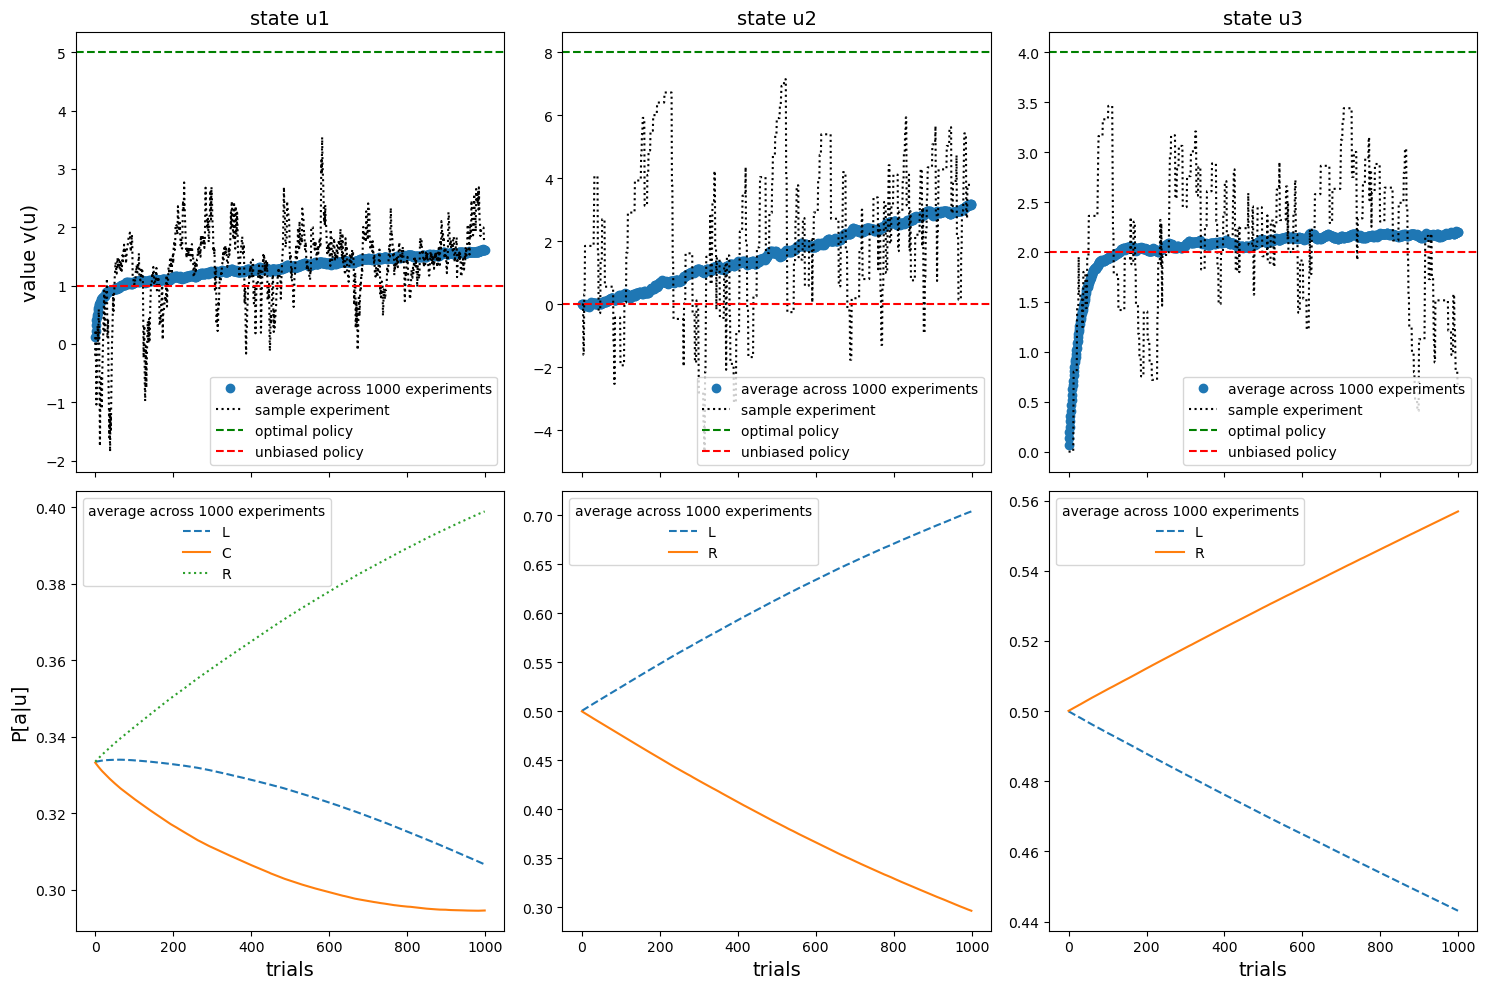

In [13]:
#low beta, i.e. we expect more exploratory behavior which will be more noisy, but probably still convergent

actor_critic_lowbeta = Levers()

values_lowbeta, probs_lowbeta = actor_critic_lowbeta.run(1000, 1000, 'u1', 0.01, 0.2, 0.075, 0)

actor_critic_lowbeta.plot_results(values_lowbeta, probs_lowbeta, 1000)

### Playing around with the parameters, pt. II: Relation of actor and critic learning rates

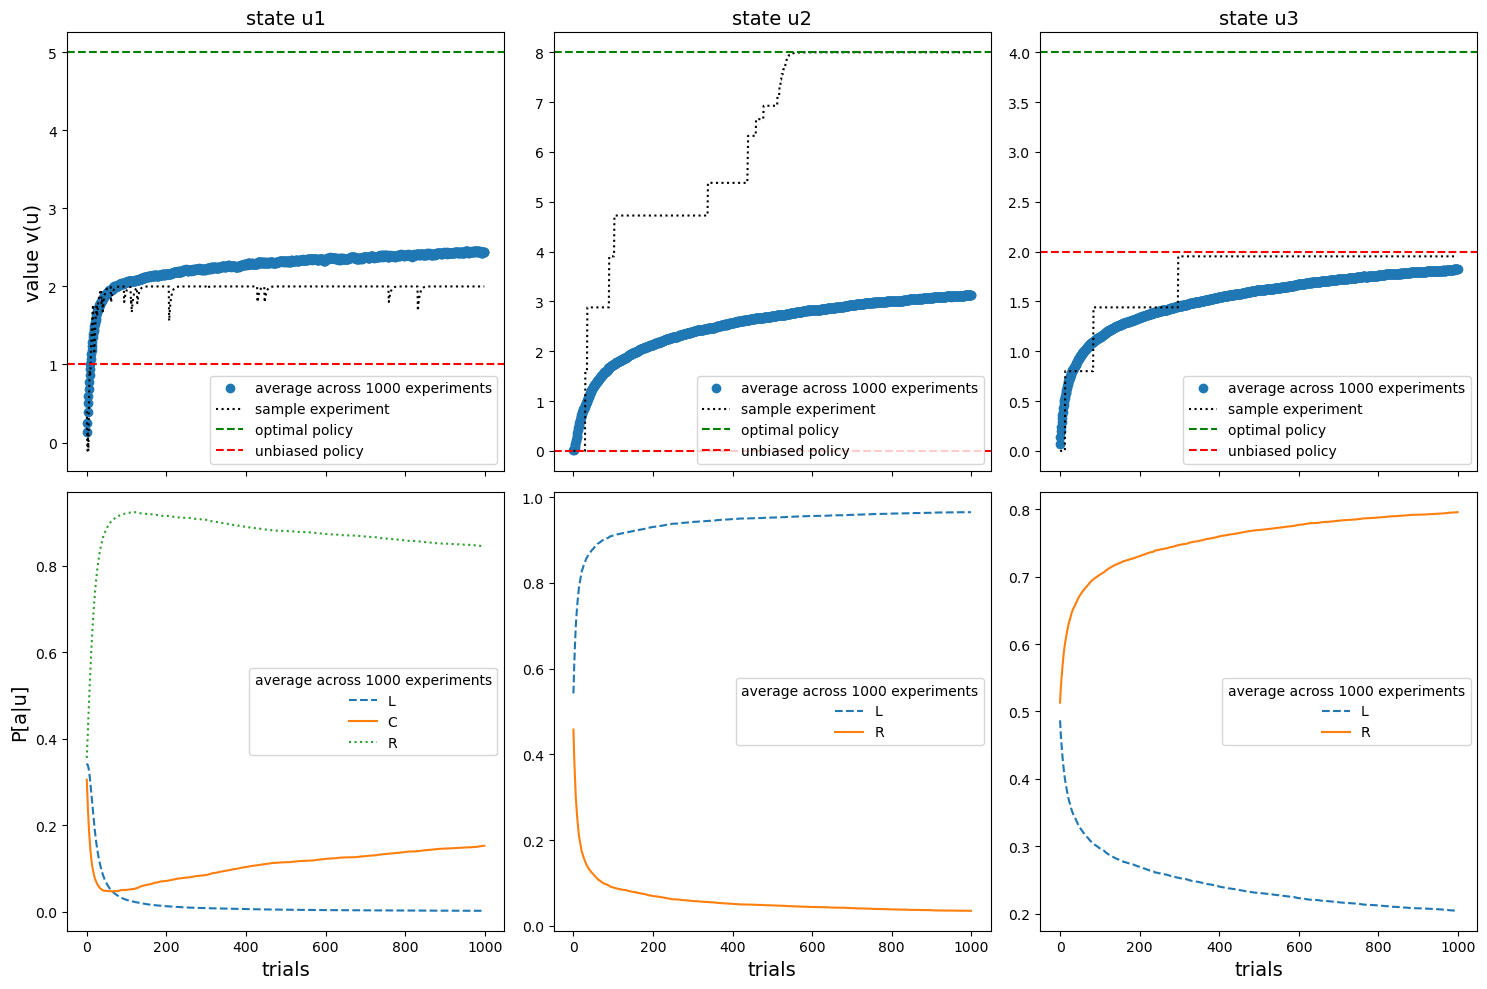

In [19]:
# increased actor learning rate

actor_critic = Levers()

values, probs = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.15, 0)

actor_critic.plot_results(values, probs, 1000)

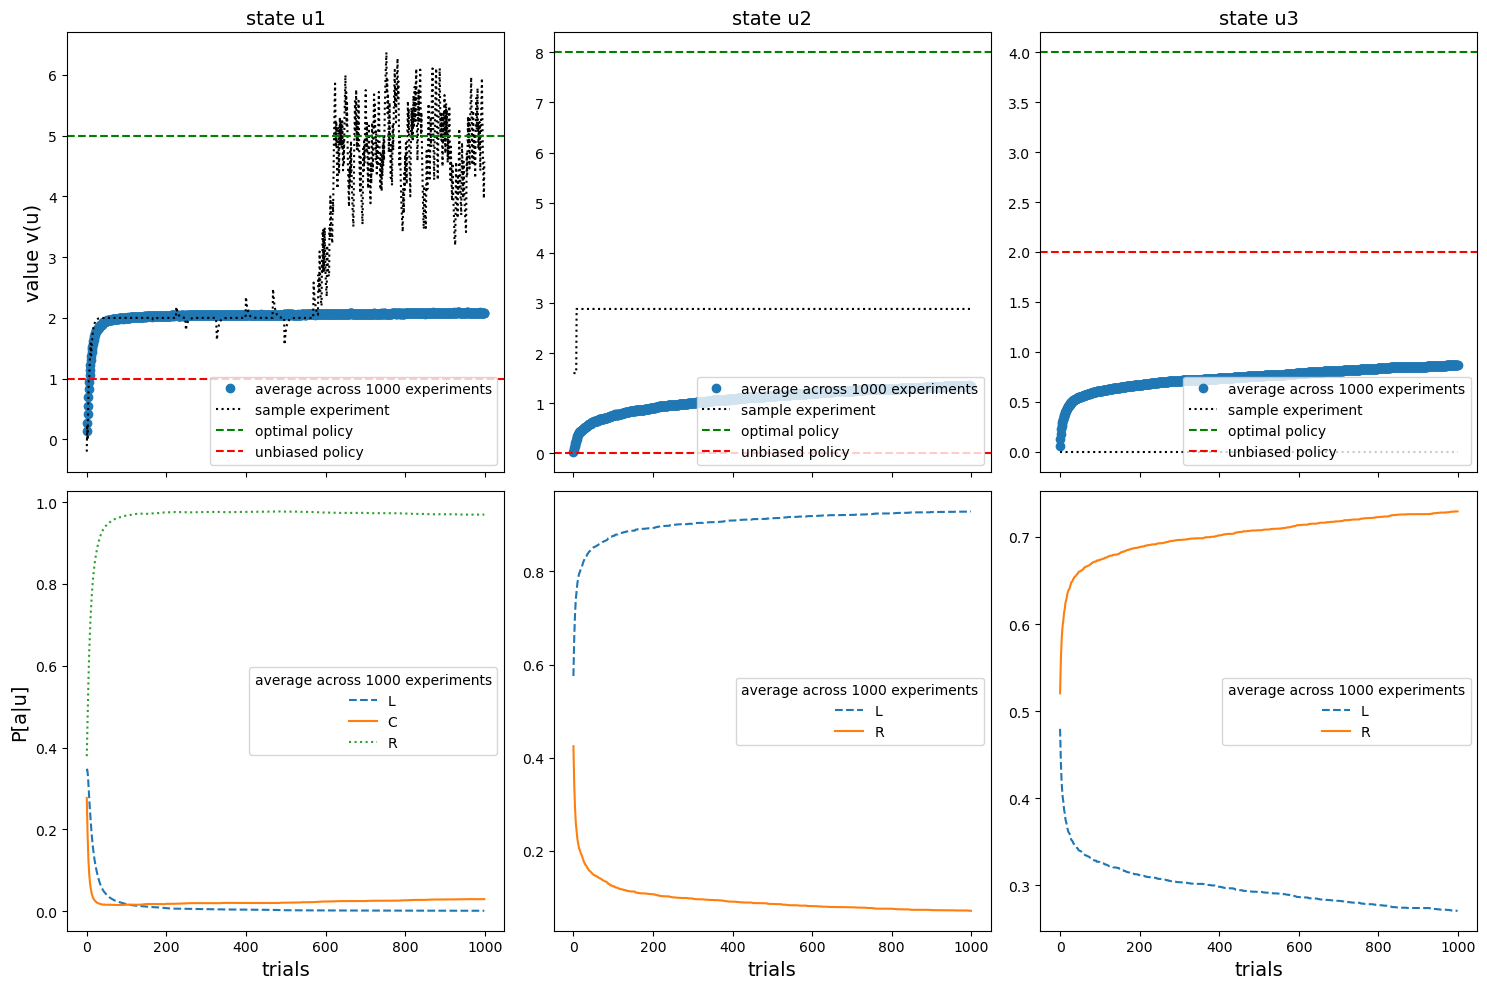

In [21]:
# equal actor and critic learning rates

actor_critic = Levers()

values, probs = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.3, 0)

actor_critic.plot_results(values, probs, 1000)

### Playing around with the parameters, pt. III: Increasing the decay parameter, i.e. decreasing reward memory

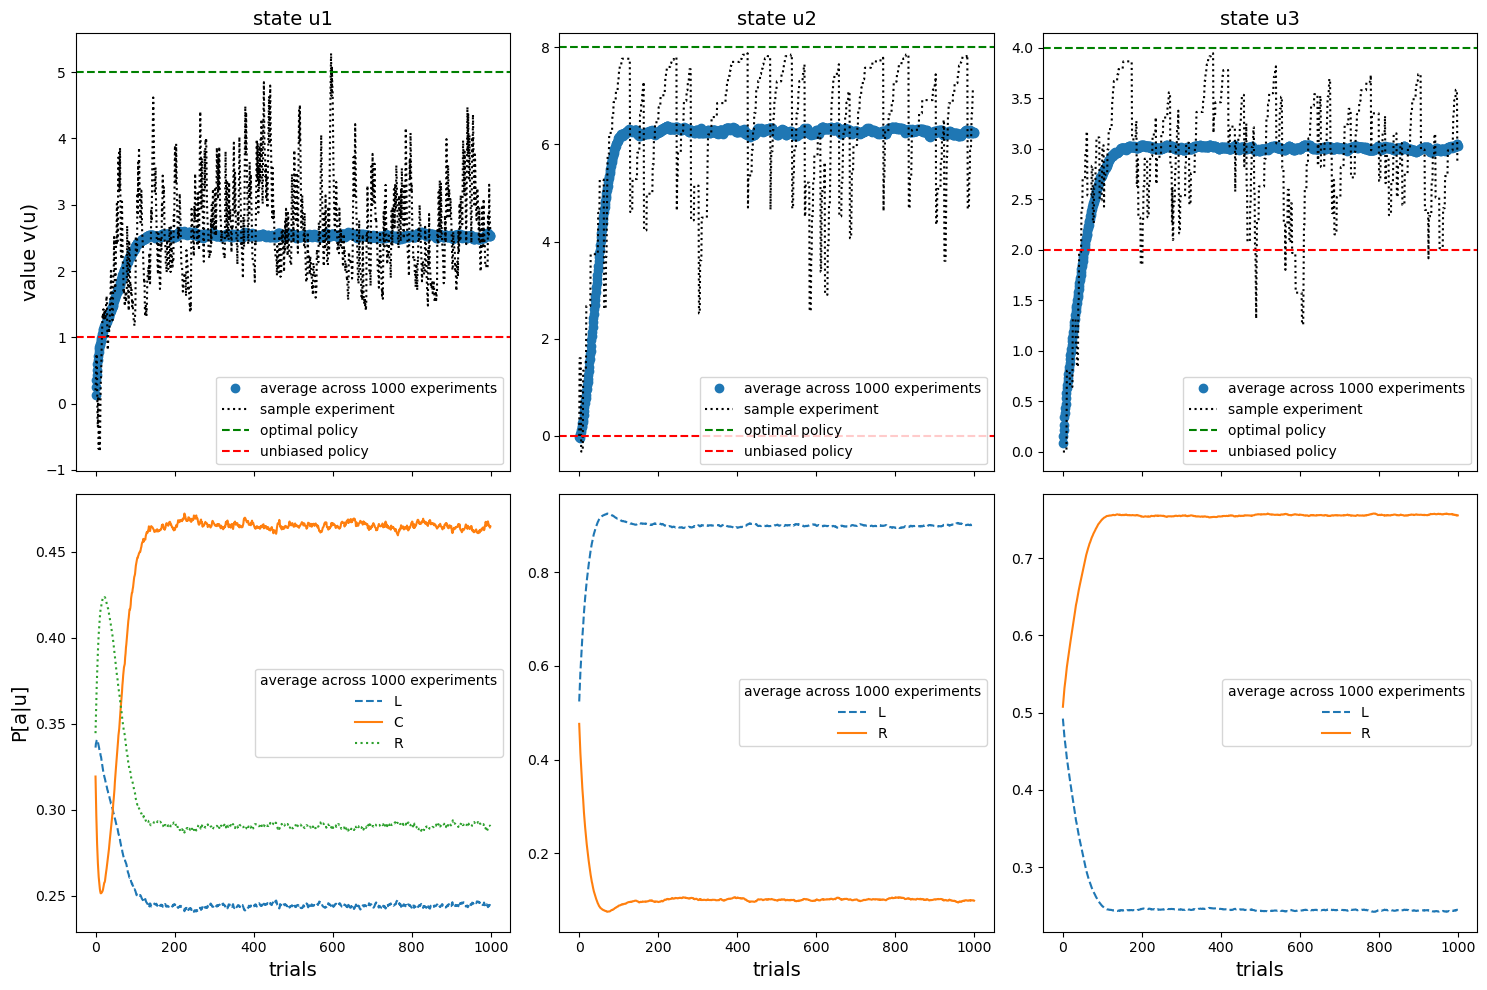

In [16]:
#nonzero decay rate

actor_critic = Levers()

values, probs = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.075, 0.1)

actor_critic.plot_results(values, probs, 1000)

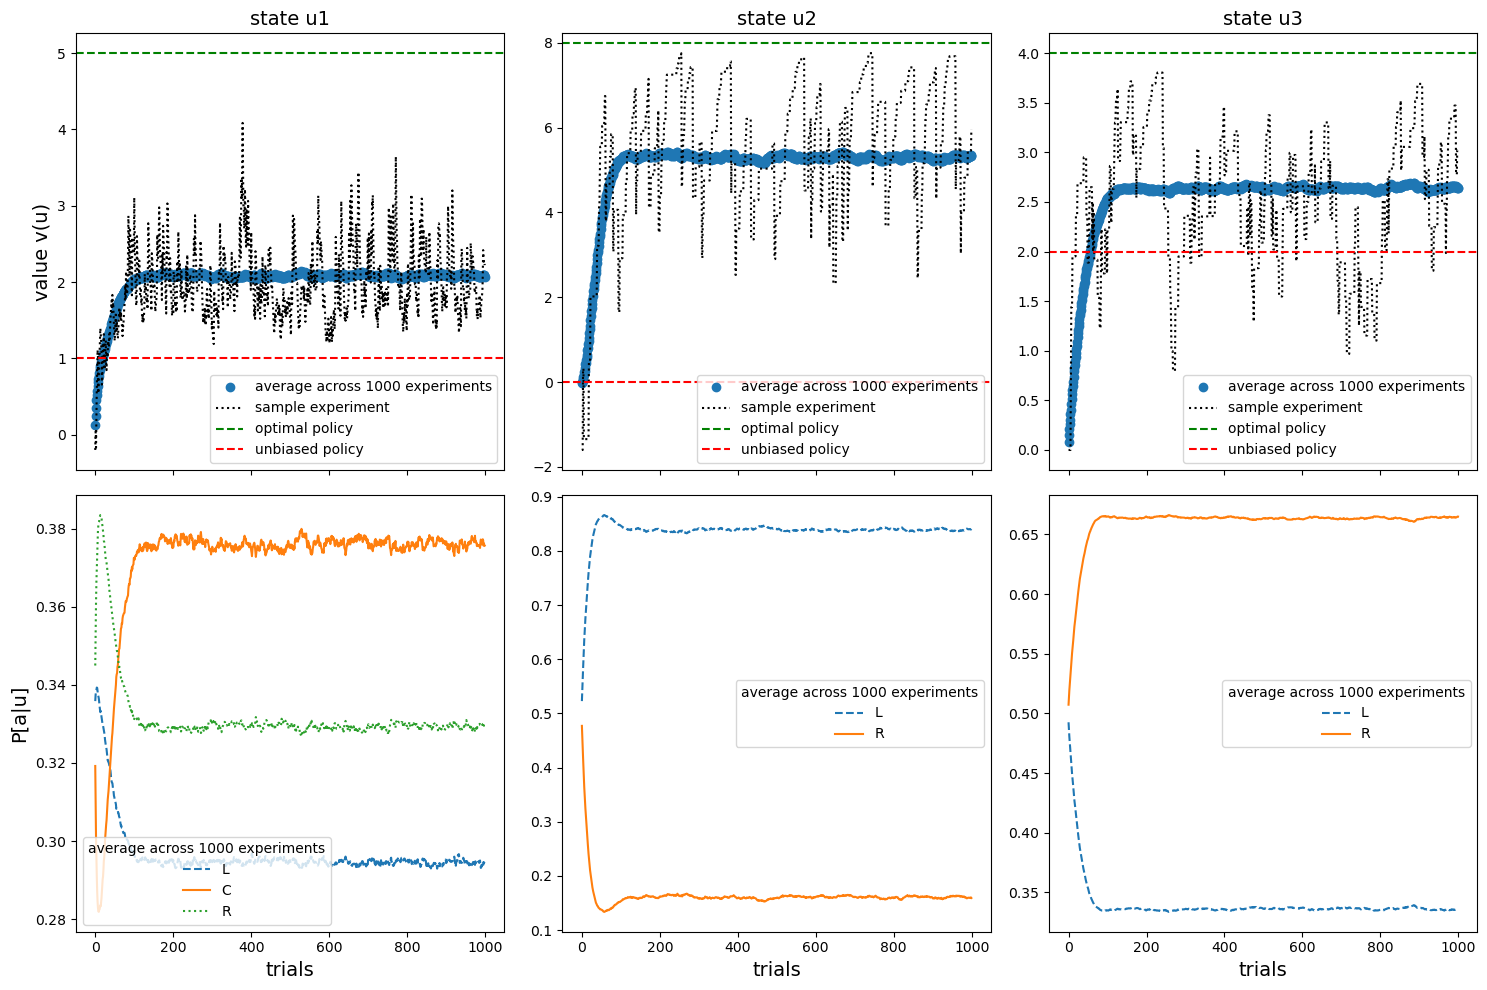

In [18]:
#even higher decay rate 

actor_critic = Levers()

values, probs = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.075, 0.2)

actor_critic.plot_results(values, probs, 1000)

In [ ]:
#even higher decay rate 

actor_critic = Levers()

values, probs = actor_critic.run(1000, 1000, 'u1', 1, 0.2, 0.075, 0.2)

actor_critic.plot_results(values, probs, 1000)

## Implementing Actor-Critic Learning for a Maze Task

### Implementing the maze structure

In [9]:
class Maze:
    def __init__(self):
        # defining states, actions, and rewards via dictionaries
        self.layers = 2 # maximal number of subsequent choices in the maze
        self.states = ['u1', 'u2', 'u3']
        self.actions = {'u1': ['L', 'R'],
                        'u2': ['L', 'R'],
                        'u3': ['L', 'R']}
        self.rewards = {'u1': {'L': 0, 'R': 0},
                        'u2': {'L': 4, 'R': 0},
                        'u3': {'L': 2, 'R': 3}}
        self.states_values = {'u1': 0, 
                              'u2': 0, 
                              'u3': 0,
                              None: 0} # initializing the value function on the states, which will be updated while going through the labyrinth
        self.actions_values = {'u1': {'L': 0, 'C': 0, 'R': 0},
                               'u2': {'L': 0, 'R': 0},
                               'u3': {'L': 0, 'R': 0}}

    def step(self, state, action): # defining the possible action-dependent state transitions

        if state == 'u1' and action == 'L':
            next_state = 'u2'
        
        elif state == 'u1' and action == 'R':
            next_state = 'u3'
       
        else:
            next_state = None

        reward = self.rewards[state][action]
        
        return next_state, reward
    
    def policy(self, state, beta): # calculating the current probability values for choosing an action in the current state based on current action values and softmax formula

        actions_factors = []
        actions_probs = []
        norm_prob = 0

        for poss_act in self.actions[state]:
            
            act_factor = np.exp(beta * self.actions_values[state][poss_act])
            actions_factors.append(act_factor)

            norm_prob += act_factor

        actions_probs = [a/norm_prob for a in actions_factors]

        return actions_probs
    
    def run(self, no_runs, no_trials, start_state, beta, learn_rate_critic, learn_rate_actor, decay_rate):

        values_hist = np.zeros((no_runs, no_trials, 3))
        probs_hist = np.zeros((no_runs, no_trials, 3, 2))


        for k in range(no_runs): 
            
            self.states_values = {'u1': 0, 
                                  'u2': 0, 
                                  'u3': 0,
                                  None: 0}

            self.actions_values  = {'u1': {'L': 0, 'R': 0},
                                'u2': {'L': 0, 'R': 0},
                                'u3': {'L': 0, 'R': 0}}

            for n in range(no_trials):

                state = start_state
                
                for step in range(self.layers):

                    if state is not None:

                        probs = self.policy(state, beta)
                        action = np.random.choice(self.actions[state], p=probs)

                        next_state, reward = self.step(state, action)

                        delta = reward + self.states_values[next_state] - self.states_values[state]
                        
                        self.states_values[state] += learn_rate_critic * delta
                        
                        for poss_act in self.actions[state]:
                            
                            self.actions_values[state][poss_act] *= (1 - decay_rate)
                        
                        self.actions_values[state][action] += learn_rate_actor * delta
                        
                        state = next_state

                for id in range(3): #store state values and action probabilities for each state after each trial in a big 'history array' of values and probabilities, resp.

                    for id_act in range(len(self.actions[self.states[id]])):
                        
                        probs_hist[k, n, id, id_act] += self.policy(self.states[id], beta)[id_act]

                    values_hist[k, n, id] = self.states_values[self.states[id]]
    
        return values_hist, probs_hist
        
    def plot_results(self, values_array, probs_array, no_runs):

        fig, axs = plt.subplots(2, len(self.states), figsize=(15, 10), sharex='col')
        styles = ['--', '', ':']

        axs[0, 0].set_ylabel('value v(u)', fontsize=14)
        axs[1, 0].set_ylabel('P[a|u]', fontsize=14)

        for id in range(len(self.states)):

            axs[0, id].set_title(f'state {self.states[id]}', fontsize=14)
            axs[0, id].plot(np.average(values_array[:, :, id], axis=0), 'o',
                       label='average across %s experiments'%no_runs)
            axs[0, id].plot(values_array[np.random.randint(0, no_runs), :, id],
                       'k:', label='sample experiment')
            axs[0, id].legend(loc='lower right')

            for id_act in range(len(self.actions[self.states[id]])):
                
                axs[1, id].plot(np.average(probs_array[:, :, id, id_act],
                            axis=0), styles[id_act], label=self.actions[self.states[id]][id_act])
                axs[1, id].legend(title='average across %s experiments'%no_runs)
                axs[1, id].set_xlabel('trials', fontsize=14)

        axs[0][0].axhline(y=4, color='g', linestyle='--', label='optimal policy')
        axs[0][0].axhline(y=2.25, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][0].legend(loc='lower right')

        axs[0][1].axhline(y=4, color='g', linestyle='--', label='optimal policy')
        axs[0][1].axhline(y=2, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][1].legend(loc='lower right')
        axs[0][2].axhline(y=3, color='g', linestyle='--', label='optimal policy')
        axs[0][2].axhline(y=2.5, color='r', linestyle='--',
                        label='unbiased policy')
        axs[0][2].legend(loc='lower right')

        plt.tight_layout()
        plt.show()

### Plots for actor-critic learning in a maze with reasonable learning parameters

In [10]:
actor_critic_maze = Maze()
values_maze, probs_maze = actor_critic_maze.run(1000, 1000, 'u1', 1, 0.2, 0.075, 0)

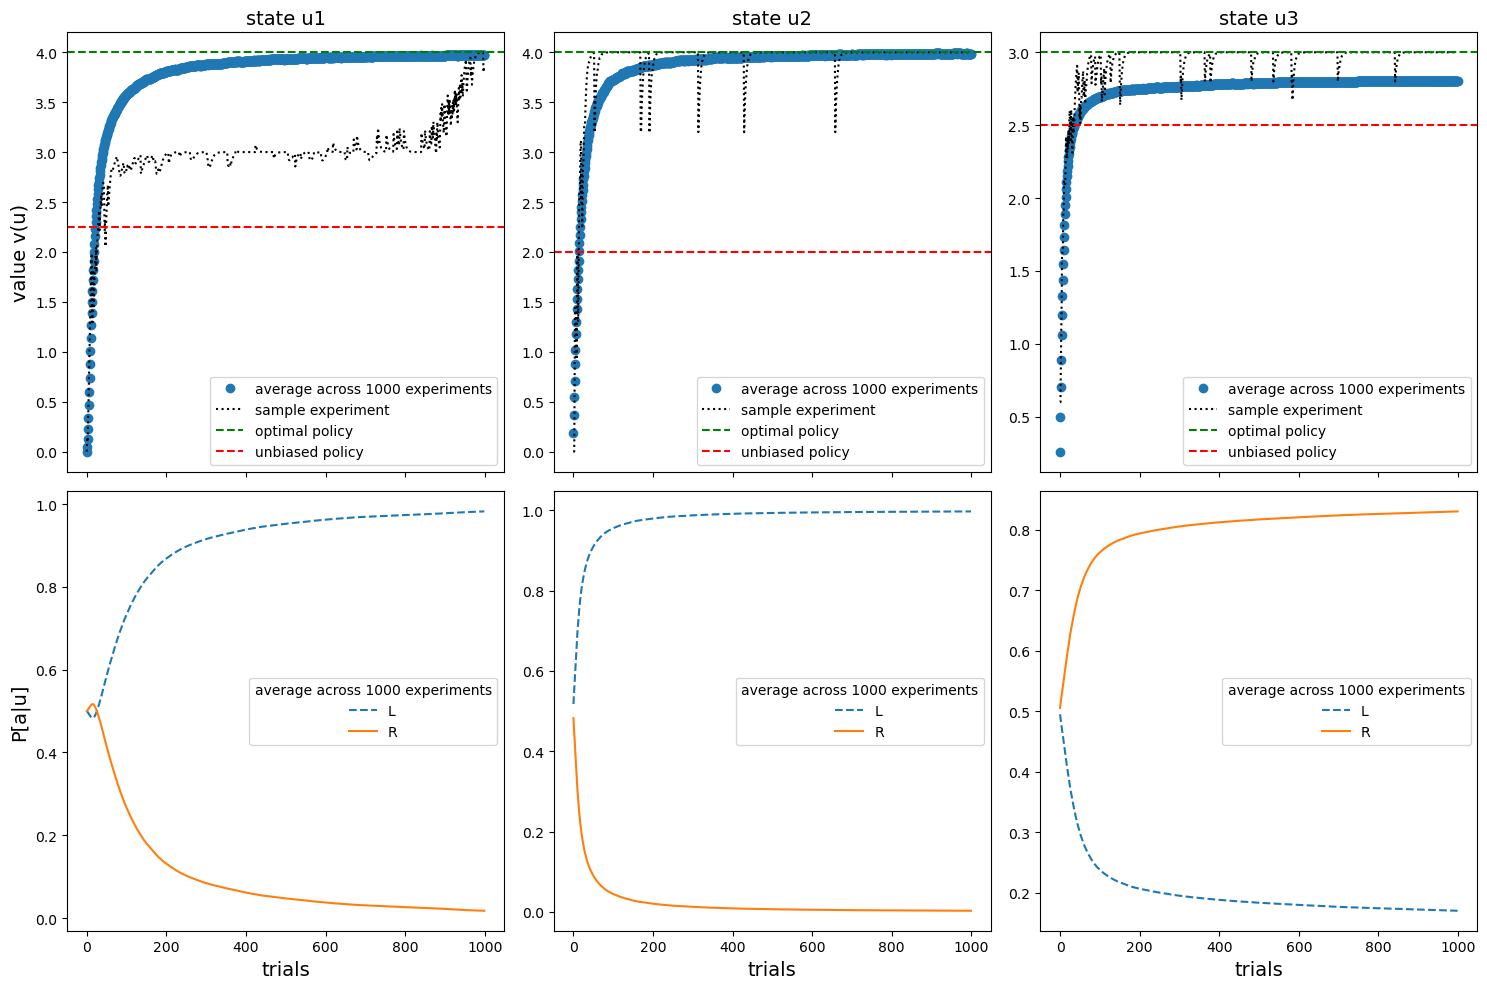

In [11]:
actor_critic_maze.plot_results(values_maze, probs_maze, 1000)


### Low beta: the exploration case

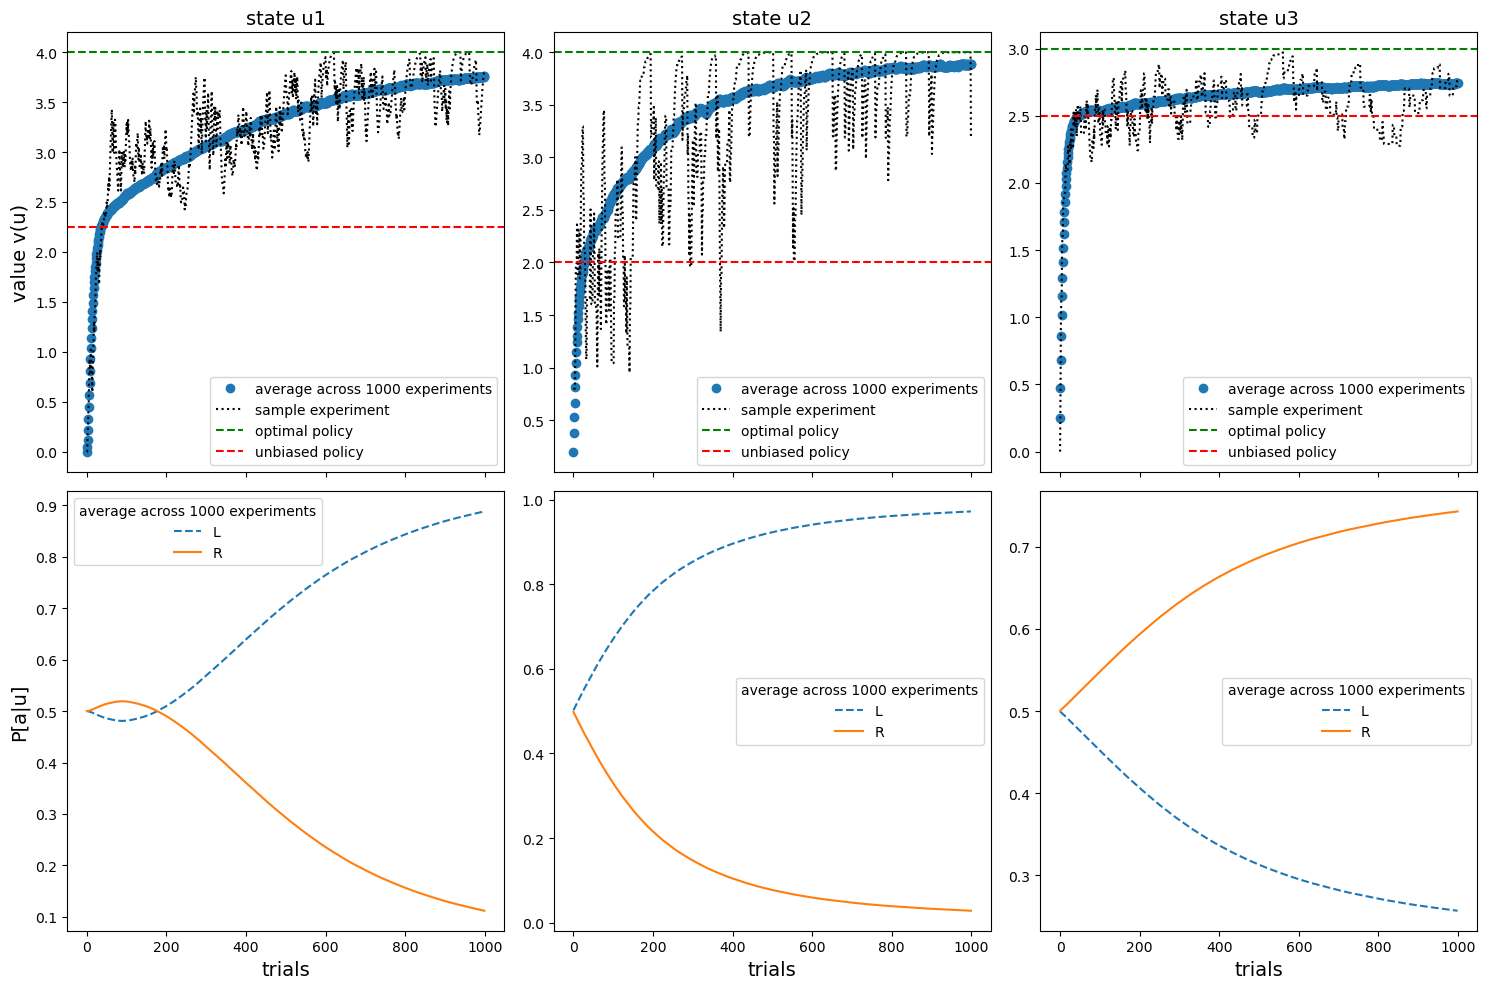

In [12]:
actor_critic_maze = Maze()
values_maze, probs_maze = actor_critic_maze.run(1000, 1000, 'u1', 0.1, 0.2, 0.075, 0)
actor_critic_maze.plot_results(values_maze, probs_maze, 1000)